Tensor Field Networks

Implementation of Newtonian gravity demonstration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import random
from math import sqrt
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tensorfieldnetworks import utils, layers
from tensorfieldnetworks.utils import EPSILON, FLOAT_TYPE
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

2026-01-10 14:18:38.716208: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-10 14:18:40.192368: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-10 14:18:45.141107: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/salih/paper/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# radial basis functions
rbf_low = 0.
rbf_high = 2.
rbf_count = 30
rbf_spacing = (rbf_high - rbf_low) / rbf_count
centers = tf.lin_space(rbf_low, rbf_high, rbf_count)

In [4]:
# [N, 3]
r = tf.placeholder(FLOAT_TYPE, shape=[None, 3])

# [N, 1, 1]
masses = tf.placeholder(FLOAT_TYPE, shape=[None, 1, 1])

# [N, N, 3]
rij = utils.difference_matrix(r)

# [N, N]
dij = utils.distance_matrix(r)

# rbf : [N, N, rbf_count]
gamma = 1. / rbf_spacing
rbf = tf.exp(-gamma * tf.square(tf.expand_dims(dij, axis=-1) - centers))

# shifted softplus
nonlin = utils.ssp

hidden_dim = rbf_count
output_dim = 1

# single layer, 0 -> 1
with tf.variable_scope(None, "layer1", values=[masses]):
    # [N, 1, 3]
    output = layers.filter_1_output_1(masses, rbf, rij, nonlin=nonlin, 
                                      hidden_dim=hidden_dim, output_dim=output_dim, 
                                      weights_initializer=tf.glorot_uniform_initializer(),
                                      biases_initializer=tf.glorot_uniform_initializer())
    
# accel : [N, 1, 3]
accel = tf.placeholder(FLOAT_TYPE, shape=[None, 1, 3])

# loss : []
loss = tf.nn.l2_loss(accel - output)

optim = tf.train.AdamOptimizer(learning_rate=1.e-3)

train_op = optim.minimize(loss)

In [5]:
# for plotting

# x : []
x = tf.placeholder(FLOAT_TYPE, shape=(None))

# rbf_plot : [rbf_count]
rbf_plot = tf.exp(-gamma * tf.square(x - centers))

for v in tf.global_variables():
    if 'layer1/F1_to_1/F_1/radial_function/weights1' in v.name and "Adam" not in v.name:
        w1 = v
    elif 'layer1/F1_to_1/F_1/radial_function/biases1' in v.name and "Adam" not in v.name:
        b1 = v
    elif 'layer1/F1_to_1/F_1/radial_function/weights2' in v.name and "Adam" not in v.name:
        w2 = v
    elif 'layer1/F1_to_1/F_1/radial_function/biases2' in v.name and "Adam" not in v.name:
        b2 = v
        
hidden_layer_plot = nonlin(b1 + tf.tensordot(rbf_plot, w1, [[0], [1]]))
R_plot = b2 + tf.tensordot(hidden_layer_plot, w2, [[0], [1]])

In [8]:
def accelerations(points, masses=None):
    """
    inputs:
    -points: a list of 3-tuples of point coordinates
    -masses: a list (of equal length N) of masses
    
    returns: 
    -shape [N, 3] numpy array of accelerations under Newtonian gravity
    """
    accels = []
    if masses is None:
        masses = [1.0 for _ in range(len(points))]
    for i, ri_ in enumerate(points):
        accel_vec = np.array((0., 0., 0.))
        for j, rj_ in enumerate(points):
            rij_ = ri_ - rj_
            dij_ = np.linalg.norm(rij_)
            if (ri_ != rj_).any():
                accel_update = -rij_ / (np.power(dij_, 3) + EPSILON) * masses[j]
                accel_vec += accel_update
        accels.append(accel_vec)
    assert len(accels) == len(points)
    return np.array(accels)


def random_points_and_masses(max_points=10, min_mass=0.5, max_mass=2.0, 
                             max_coord=rbf_high, min_separation=0.5):
    """
    returns:
    -shape [N, 3] numpy array of points, where N is between 2 and max_points
    -shape [N] numpy array of masses
    """
    num_points = random.randint(2, max_points)
    candidate_points = []
    for point in range(num_points):
        candidate_points.append(
            np.array([random.uniform(-max_coord, max_coord) for _ in range(3)]))
    
    # remove points that are closer than min_separation
    output_points = []
    for point in candidate_points:
        include_point = True
        for previous_point in output_points:
            if np.linalg.norm(point - previous_point) < min_separation:
                include_point = False
        if include_point:
            output_points.append(point)
    
    points_ = np.array(output_points)
    masses_ = np.random.rand(len(output_points)) * (max_mass - min_mass) + min_mass
    return points_, masses_

In [9]:
max_steps = 1001
validation_size = 1000
print_freq = 1000

F1_y_vals = []
x_vals = [index * rbf_high / rbf_count for index in range(rbf_count + 1)]

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# training
min_separation = 0.5
for step in range(max_steps):
    rand_points, rand_masses = random_points_and_masses(max_points=10, 
                                                        min_separation=min_separation)
    rand_masses_m = np.reshape(rand_masses, [len(rand_masses), 1, 1])
    sess.run(train_op, feed_dict={r: rand_points, 
                                  masses: rand_masses_m, 
                                  accel: np.expand_dims(accelerations(rand_points,
                                                                      rand_masses), axis=-2)})
    
    # print performance on different random point set every print_freq steps
    if step % print_freq == 0:
        loss_sum = 0.
        for _ in range(validation_size):
            validation_points, validation_masses = random_points_and_masses(max_points=50,
                                                                            min_separation=min_separation)
            validation_masses_m = np.reshape(validation_masses, [len(validation_masses), 1, 1])
            validation_loss = sess.run(loss, feed_dict={r: validation_points, 
                                                        masses: validation_masses_m, 
                                                        accel: np.expand_dims(
                                                            accelerations(validation_points, 
                                                                          validation_masses), axis=-2)})
            loss_sum += validation_loss
        print("Step %d: validation loss = %.3f" % (step, loss_sum / validation_size))

        # for plotting radial function
        y_vals = []
        for x_val in x_vals:
            y_vals.append(sess.run(R_plot, feed_dict={x: x_val}))
        F1_y_vals.append((step, y_vals))

Step 0: validation loss = 336.110
Step 1000: validation loss = 1.267


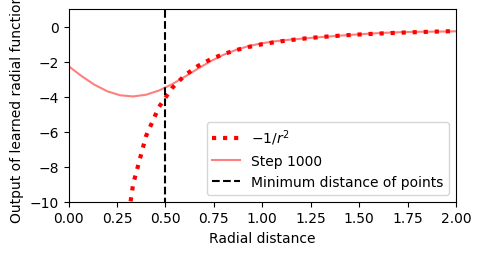

In [10]:
# plot radial function and compare with -1/r^2

radial_fig = plt.figure(figsize=(5,2.5))
ax = radial_fig.add_subplot(1,1,1)

min_index_cutoff = int((1 / sqrt(40.) - rbf_low) / rbf_spacing)
ax.plot(x_vals[min_index_cutoff:], [-1 / r_**2 for r_ in x_vals[min_index_cutoff:]], "r:", lw=3, label="$-1/r^2$")

for step, y_vals in F1_y_vals[1:]:
    line, = ax.plot(x_vals, y_vals, 'r', alpha=0.5, label="Step {}".format(step))
    line.set_ydata(y_vals)

ax.plot([min_separation, min_separation], [10,-50], 'k--', label="Minimum distance of points")
ax.set_ylabel("Output of learned radial function.")
ax.set_xlabel("Radial distance")
ax.set_xlim(0., 2.0)
ax.set_ylim(-10, 1.)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
radial_fig.canvas.draw()